# install dependancies, takes around 45 seconds

Rendering Dependancies



Pacman Dependancies

# Imports and Helper functions


In [23]:
import sys, os, copy
from pathlib import Path
proj_folder = Path('.').absolute()

In [24]:
import numpy as np, torch, gym
import torch.nn.functional as F
# from a2c import A2C
# from net import NeuralNet
from gym.wrappers import record_video
#
from gym import logger as gymlogger
from gym.wrappers import record_video
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay

In [25]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""
def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env, save_path=proj_folder/'video'):
    save_path.mkdir(parents=True, exist_ok=True)
    env = record_video(env, proj_folder/'video', name_prefix='train')
    return env

# Run Simulations!

In [ ]:
import numpy as np, torch, gym
import torch.nn.functional as F
from gym.wrappers import record_video
#
from gym import logger as gymlogger
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
global DEBUG
device = 'cuda' if torch.cuda.is_available() else 'cpu'
DEBUG=False

In [30]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, output_size, activation, layers=[32,32,16]):
        super().__init__()

        self.linear1 = torch.nn.Linear(input_size, layers[0])
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(layers[0], layers[1])
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(layers[1], layers[2])
        self.activation3 = torch.nn.ReLU()

        self.output_layer = torch.nn.Linear(layers[2], output_size)
        self.output_activation = activation

        #initialize weights, following 'fan_avg' approach
        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.xavier_normal_(self.output_layer.weight)

    def forward(self, inputs):
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_activation(self.output_layer(x))
        return x

    def fit(self, loss, optimizer):
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

class A2C(object):
    # Implementation of N-step Advantage Actor Critic.

    def __init__(self, actor, actor_lr, N, nA, critic, critic_lr, baseline=False, a2c=True):
        # Note: baseline is true if we use reinforce with baseline
        #       a2c is true if we use a2c else reinforce
        
        # TODO: Initializes A2C.
        self.type = "A2C" if a2c else ("Baseline" if baseline else "Reinforce")  # Pick one of: "A2C", "Baseline", "Reinforce"
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        actor.to(device)
        # define meta variabless
        self.save_dir = Path('./').absolute()/'Output'
        if self.type == "A2C":
            critic.to(device)
            self.critic_optimizer = torch.optim.Adam(critic.parameters(), lr=critic_lr)
        elif self.type == "Baseline":
            pass
        else:
            # Reinforce
            pass
        self.actor = actor
        self.actor_optimizer = torch.optim.Adam(actor.parameters(), lr=actor_lr)
        self.N = N
        assert self.type is not None, "Type must be provided"

    def reinforce_criterion(self, y_pred, y_true):
        log_y_pred = torch.log(y_pred)   # log probability of ation
        l = torch.multiply(log_y_pred, y_true)   # (n_eps, nA)
        l_action = torch.sum(l, axis=1)  # (n_eps,)
        return torch.mean(l_action)
    
    def fit_actor(self, states, G_total, epochs=1, batch_size=1):
        """
        """
        self.actor.train()
        n_example = len(states)
        history = dict.fromkeys(['loss'],[])
        for e in range(epochs):
            for i in range(int(np.ceil(len(states)/batch_size))):
                start_idx, end_idx = batch_size*i, min(batch_size*(i+1), n_example)
                states_, target_ = states[start_idx: end_idx], G_total[start_idx: end_idx]
                pred_G = self.actor(states_.cuda())
                loss = self.reinforce_criterion(pred_G, target_.cuda())
                # # measure metrics and record loss
                # m1 = metric1(cls_out.cpu(), target)
                # m2 = metric2(cls_out.cpu(), target)
                history['loss'].append(loss)
                self.actor_optimizer.zero_grad()
                loss.backward()
                self.actor_optimizer.step()
                if DEBUG: print(f"Latest Loss:{history['loss'][-1]}")
        return history

    def evaluate_policy(self, env):
        # TODO: Compute Accumulative trajectory reward(set a trajectory length threshold if you want)
        """ compute rewards
        """
        self.actor.eval()
        _, _, r, _ = self.generate_episode(env, render=False)
        rtot = np.sum(np.array(r))
        return rtot

    def generate_episode(self, env, render=False):
        """
		# Generates an episode by executing the current policy in the given env.
		# Returns:
		# - a list of states, indexed by time step
            shape: (t)
		# - a list of actions, indexed by time step
            shape: (t, nA)
		# - a list of rewards, indexed by time step
            shape: (t)
        """
        states, actions, rewards, actions_probs=[], [] ,[], []
        # 
        nS = env.observation_space.shape[0]
        nA = env.action_space.n
		# Start episode
        states.append(np.expand_dims(env.reset(), axis=0))
        terminal = False
        if render: env.render(mode='human')
        cts = 0
        while not terminal:
            cts+=1
            ac = self.actor(torch.Tensor(states[-1]).to(device)).squeeze(0)   # ensure [nA] vector
            if DEBUG: print(f"Input state:{states[-1]}\nOutput action:{ac}")
            ac_prob = ac.detach().cpu().numpy().flatten()
            ac_prob = np.nan_to_num(ac_prob,0)
            #
            a_ = np.random.choice(ac_prob, p=ac_prob)   # stochastic choice
            curr_ac = np.where(ac_prob==a_)[0][0]  # Current Action
            action_OH = np.eye(nA)[curr_ac]  # one-hot action
            
            # move in direction and get environment output
            s, r, terminal, _ = env.step(curr_ac)
            # add to history
            states.append(np.expand_dims(s, axis=0))
            actions.append(action_OH)
            actions_probs.append(ac_prob)
            rewards.append(r)
            curr_state = copy.deepcopy(s)
        if DEBUG: print(f"action probs:{ac_prob}\nfinal action:{action_OH}")
        print("Finished after {} timesteps".format(cts+1))
		# flatten 
        states=np.reshape(np.array(states), (-1, nS))
        actions=np.reshape(np.array(actions), (-1, nA))
        return np.stack(states), np.stack(actions), np.stack(rewards), np.stack(actions_probs)

    def train(self, env, gamma=0.99, n=10):
        """
        # Trains the model on a single episode using REINFORCE or A2C/A3C.
        params:
            n: number of n-steps look ahead
        """
        # TODO: Implement this method. It may be helpful to call the class
        #       method generate_episode() to generate training data.
        eps_lim = 500    # length of episode 'limit'
        batch_size_ratio = 1    # portion of length of states to feed in NN
        alpha = 1e-2
        assert 0<batch_size_ratio<=1, "Batch size between 0 and 1"
        #
        env = wrap_env(env)
        mean_total, std_total = [], []
        # generate episode
        states, actions, rewards, actions_prob = self.generate_episode(env, render=True)
        states = states[:-1]   # remove the last state
        # get discounted reward vector
            # [sum : r*gamma*0...r*gamma*n]
        G_tot=[0]
        for n_gamma, r in enumerate(reversed(rewards)):
            # insert from last reward to beginning 
            G_tot.insert(0, r+gamma**n_gamma*G_tot[0])
        if DEBUG: print(f"Sum of Expected Rewards G:{G_tot}")
        G_tot=np.array(G_tot[:-1])
        # weight actions by rewards and fit model
        if DEBUG: print(f"G_tot:[{len(G_tot)}], actions:[{len(actions)}], states:[{len(states)}]")
        G_total_actions = np.multiply(G_tot, actions.T).T   # (t, nA)
        train_history = self.fit_actor(torch.Tensor(states), torch.Tensor(G_total_actions*alpha), epochs=1, batch_size=int(len(states)*batch_size_ratio))
        return train_history

# Run

In [31]:
import argparse, matplotlib.pyplot as plt, tqdm
def parse_a2c_arguments():
    # Command-line flags are defined here.
    parser = argparse.ArgumentParser()
    parser.add_argument('--env-name', dest='env_name', type=str,
                        default='CartPole-v0', help="Name of the environment to be run.")   # 'LunarLander-v2'
    parser.add_argument('--num-episodes', dest='num_episodes', type=int,
                        default=100, help="Number of episodes to train on.")
    parser.add_argument('--lr', dest='lr', type=float,
                        default=5e-4, help="The actor's learning rate.")
    parser.add_argument('--baseline-lr', dest='baseline_lr', type=float,
                        default=5e-4, help="The actor's learning rate.")
    parser.add_argument('--critic-lr', dest='critic_lr', type=float,
                        default=1e-4, help="The critic's learning rate.")
    parser.add_argument('--n', dest='n', type=int,
                        default=100, help="The value of N in N-step A2C.")

    parser_group = parser.add_mutually_exclusive_group(required=False)
    parser_group.add_argument('--render', dest='render',
                              action='store_true',
                              help="Whether to render the environment.")
    parser_group.add_argument('--no-render', dest='render',
                              action='store_false',
                              help="Whether to render the environment.")
    parser.set_defaults(render=False)

    return parser.parse_known_args()[0]    #.parse_args()

Configurations:Namespace(baseline_lr=0.0005, critic_lr=0.0001, env_name='CartPole-v0', lr=0.0005, n=100, num_episodes=100, render=False)


  0%|                                                                                       | 0/5 [00:00<?, ?it/s]

Episode: 0
Finished after 13 timesteps
[Policy Evaluation]
Finished after 25 timesteps
Finished after 12 timesteps
Finished after 39 timesteps
Finished after 20 timesteps
Finished after 35 timesteps
Finished after 14 timesteps
Finished after 26 timesteps
Finished after 15 timesteps
Finished after 30 timesteps
Finished after 19 timesteps
Finished after 29 timesteps
Finished after 13 timesteps
Finished after 22 timesteps
Finished after 22 timesteps
Finished after 15 timesteps
Finished after 12 timesteps
Finished after 10 timesteps
Finished after 13 timesteps
Finished after 31 timesteps
Finished after 11 timesteps
The test reward for episode 0 is 19.65 with sd of 8.492791060658446.
Episode: 1
Finished after 10 timesteps
Episode: 2
Finished after 32 timesteps
Episode: 3
Finished after 17 timesteps
Episode: 4
Finished after 45 timesteps
Episode: 5
Finished after 15 timesteps
Episode: 6
Finished after 20 timesteps
Episode: 7
Finished after 13 timesteps
Episode: 8
Finished after 11 timesteps


 20%|███████████████▊                                                               | 1/5 [01:00<04:00, 60.14s/it]

Finished after 15 timesteps
Episode: 0
Finished after 31 timesteps
[Policy Evaluation]
Finished after 16 timesteps
Finished after 27 timesteps
Finished after 25 timesteps
Finished after 48 timesteps
Finished after 16 timesteps
Finished after 16 timesteps
Finished after 12 timesteps
Finished after 14 timesteps
Finished after 70 timesteps
Finished after 15 timesteps
Finished after 23 timesteps
Finished after 20 timesteps
Finished after 19 timesteps
Finished after 26 timesteps
Finished after 17 timesteps
Finished after 19 timesteps
Finished after 15 timesteps
Finished after 37 timesteps
Finished after 22 timesteps
Finished after 10 timesteps
The test reward for episode 0 is 22.35 with sd of 13.74872721381874.
Episode: 1
Finished after 16 timesteps
Episode: 2
Finished after 15 timesteps
Episode: 3
Finished after 42 timesteps
Episode: 4
Finished after 20 timesteps
Episode: 5
Finished after 10 timesteps
Episode: 6
Finished after 18 timesteps
Episode: 7
Finished after 19 timesteps
Episode: 8


 40%|███████████████████████████████▌                                               | 2/5 [01:50<02:43, 54.53s/it]

Finished after 22 timesteps
Episode: 0
Finished after 16 timesteps
[Policy Evaluation]
Finished after 28 timesteps
Finished after 14 timesteps
Finished after 21 timesteps
Finished after 14 timesteps
Finished after 44 timesteps
Finished after 27 timesteps
Finished after 38 timesteps
Finished after 21 timesteps
Finished after 31 timesteps
Finished after 13 timesteps
Finished after 11 timesteps
Finished after 17 timesteps
Finished after 14 timesteps
Finished after 10 timesteps
Finished after 29 timesteps
Finished after 44 timesteps
Finished after 15 timesteps
Finished after 40 timesteps
Finished after 12 timesteps
Finished after 19 timesteps
The test reward for episode 0 is 22.1 with sd of 11.040380428228007.
Episode: 1
Finished after 31 timesteps
Episode: 2
Finished after 15 timesteps
Episode: 3
Finished after 12 timesteps
Episode: 4
Finished after 24 timesteps
Episode: 5
Finished after 15 timesteps
Episode: 6
Finished after 27 timesteps
Episode: 7
Finished after 14 timesteps
Episode: 8


Exception ignored in: <function Viewer.__del__ at 0x00000262450AD040>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda\Anaconda3\envs\ptml\lib\site-packages\gym\envs\classic_control\rendering.py", line 185, in __del__
    self.close()
  File "C:\ProgramData\Anaconda\Anaconda3\envs\ptml\lib\site-packages\gym\envs\classic_control\rendering.py", line 101, in close
    self.window.close()
  File "C:\ProgramData\Anaconda\Anaconda3\envs\ptml\lib\site-packages\pyglet\window\win32\__init__.py", line 332, in close
    super(Win32Window, self).close()
  File "C:\ProgramData\Anaconda\Anaconda3\envs\ptml\lib\site-packages\pyglet\window\__init__.py", line 858, in close
    app.windows.remove(self)
  File "C:\ProgramData\Anaconda\Anaconda3\envs\ptml\lib\_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x00000262456575E0; to 'Win32Window' at 0x0000026244FA9160>
Exception ignored in: <function VideoRecorder.__del__ at 0x0000026232FE2C10>
Trac

Finished after 44 timesteps
Episode: 22
Finished after 20 timesteps
Episode: 23
Finished after 21 timesteps
Episode: 24
Finished after 20 timesteps
Episode: 25
Finished after 27 timesteps
Episode: 26
Finished after 12 timesteps
Episode: 27
Finished after 18 timesteps
Episode: 28
Finished after 16 timesteps
Episode: 29
Finished after 11 timesteps
Episode: 30
Finished after 18 timesteps
Episode: 31
Finished after 18 timesteps
Episode: 32
Finished after 20 timesteps
Episode: 33
Finished after 11 timesteps
Episode: 34
Finished after 26 timesteps
Episode: 35
Finished after 39 timesteps
Episode: 36
Finished after 16 timesteps
Episode: 37
Finished after 23 timesteps
Episode: 38
Finished after 13 timesteps
Episode: 39
Finished after 17 timesteps
Episode: 40
Finished after 23 timesteps
Episode: 41
Finished after 12 timesteps
Episode: 42
Finished after 27 timesteps
Episode: 43
Finished after 16 timesteps
Episode: 44
Finished after 25 timesteps
Episode: 45
Finished after 30 timesteps
Episode: 46


 60%|███████████████████████████████████████████████▍                               | 3/5 [02:42<01:46, 53.33s/it]

Finished after 26 timesteps
Episode: 0
Finished after 19 timesteps
[Policy Evaluation]
Finished after 21 timesteps
Finished after 13 timesteps
Finished after 12 timesteps
Finished after 31 timesteps
Finished after 12 timesteps
Finished after 29 timesteps
Finished after 34 timesteps
Finished after 76 timesteps
Finished after 29 timesteps
Finished after 40 timesteps
Finished after 17 timesteps
Finished after 29 timesteps
Finished after 16 timesteps
Finished after 16 timesteps
Finished after 23 timesteps
Finished after 42 timesteps
Finished after 18 timesteps
Finished after 48 timesteps
Finished after 28 timesteps
Finished after 22 timesteps
The test reward for episode 0 is 26.8 with sd of 14.911740341086952.
Episode: 1
Finished after 22 timesteps
Episode: 2
Finished after 25 timesteps
Episode: 3
Finished after 21 timesteps
Episode: 4
Finished after 29 timesteps
Episode: 5
Finished after 15 timesteps
Episode: 6
Finished after 18 timesteps
Episode: 7
Finished after 27 timesteps
Episode: 8


 80%|███████████████████████████████████████████████████████████████▏               | 4/5 [03:38<00:54, 54.34s/it]

Finished after 11 timesteps
Episode: 0
Finished after 22 timesteps
[Policy Evaluation]
Finished after 47 timesteps
Finished after 29 timesteps
Finished after 18 timesteps
Finished after 27 timesteps
Finished after 20 timesteps
Finished after 13 timesteps
Finished after 19 timesteps
Finished after 11 timesteps
Finished after 17 timesteps
Finished after 40 timesteps
Finished after 30 timesteps
Finished after 19 timesteps
Finished after 15 timesteps
Finished after 29 timesteps
Finished after 13 timesteps
Finished after 16 timesteps
Finished after 17 timesteps
Finished after 12 timesteps
Finished after 37 timesteps
Finished after 43 timesteps
The test reward for episode 0 is 22.6 with sd of 10.739646176667089.
Episode: 1
Finished after 12 timesteps
Episode: 2
Finished after 17 timesteps
Episode: 3
Finished after 50 timesteps
Episode: 4
Finished after 12 timesteps
Episode: 5
Finished after 15 timesteps
Episode: 6
Finished after 13 timesteps
Episode: 7
Finished after 29 timesteps
Episode: 8


100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [04:33<00:00, 54.63s/it]

Finished after 28 timesteps


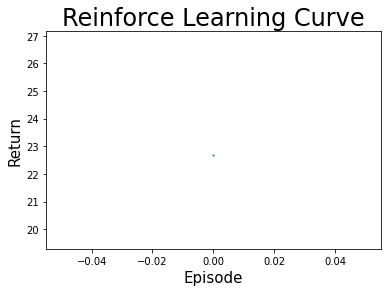

In [32]:
#def main_a2c(args):
# Parse command-line arguments.
args = parse_a2c_arguments()
env_name = args.env_name

# Create the environment.
env =  wrap_env(gym.make(env_name))
nA = env.action_space.n
nS = env.observation_space.shape[0]
num_episodes = args.num_episodes
lr = args.lr
baseline_lr = args.baseline_lr
critic_lr = args.critic_lr
render = args.render
print(f"Configurations:{args}")

# Plot average performance of 5 trials
num_seeds = 5
l = num_episodes//100
res = np.zeros((num_seeds, l))

gamma = 0.99
act_layer = torch.nn.Softmax(dim=1) 
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # TODO: create networks and setup reinforce/a2c
    history = dict.fromkeys(['train','test'],[])
    actor = NeuralNet(input_size=nS, output_size=nA, activation=act_layer)
    critic = NeuralNet(input_size=nS, output_size=nA, activation=act_layer)
    A2C_net = A2C(actor=actor, actor_lr=args.lr, N=args.n, nA=nA, 
                critic=critic, critic_lr=args.critic_lr, baseline=False, a2c=False)
    for m in range(num_episodes):
        print("Episode: {}".format(m))
        history['train'].append(A2C_net.train(env, gamma=gamma))
        if m % 100 == 0:
            print("[Policy Evaluation]")
            G = np.zeros(20)   # save 20 iterations of evaluation 
            for k in range(20):
                g = A2C_net.evaluate_policy(env)
                G[k] = g
            reward_mean = G.mean()
            reward_sd = G.std()
            print("The test reward for episode {0} is {1} with sd of {2}.".format(m, reward_mean, reward_sd))
            reward_means.append(reward_mean)
            history['test'].append(G)
    res[i] = np.array(reward_means)


ks = np.arange(l)*100
avs = np.mean(res, axis=0)
maxs = np.max(res, axis=0)
mins = np.min(res, axis=0)

plt.fill_between(ks, mins, maxs, alpha=0.1)
plt.plot(ks, avs, '-o', markersize=1)

plt.xlabel('Episode', fontsize = 15)
plt.ylabel('Return', fontsize = 15)

if not os.path.exists('./plots'):
    os.mkdir('./plots')

if A2C_net.type == 'A2C':
    plt.title("A2C Learning Curve for N = {}".format(args.n), fontsize = 24)
    plt.savefig("./plots/a2c_curve_N={}.png".format(args.n))
elif A2C_net.type == 'Baseline':
    plt.title("Baseline Reinforce Learning Curve".format(args.n), fontsize = 24)
    plt.savefig("./plots/Baseline_Reinforce_curve.png".format(args.n))
else: # Reinforce
    plt.title("Reinforce Learning Curve", fontsize = 24)
    plt.savefig("./plots/Reinforce_curve.png")   

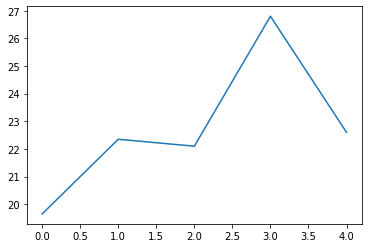

In [36]:
plt.plot(res)

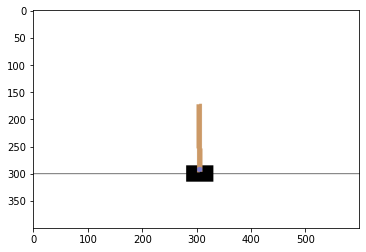

In [ ]:
env = 
states = []
states.append(np.expand_dims(env.reset(), axis=0))
for i in range(200): # Take 200 actions
    print(f"Action:{i}")
    ac = actor(torch.Tensor(states[-1]).to(device)).squeeze(0)
    ac_prob = ac.detach().cpu().numpy().flatten()
    states.append(np.expand_dims(env.reset(), axis=0))
    #
    a_ = np.random.choice(ac_prob, p=ac_prob)   # stochastic choice
    curr_ac = np.where(ac_prob==a_)[0][0]  # Current Action
    s, r, terminal, _ = env.step(curr_ac)
    # AT THIS POINT you have (state, action, reward, new_state, done)
    #### Display Code in Jupyter Notebook ####
    screen = env.render(mode='rgb_array')
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    ######################
    s, r, terminal, _ = env.step(curr_ac)
    #### Display Code for Normal Python Script ####
    # env.render()
    # time.sleep(0.02)
    ######################
    if terminal:
        break

############ Display Code ####
ipythondisplay.clear_output(wait=True)
env.close()
######################

In [ ]:
output = actor(torch.Tensor([[ 0.39646003  ,0.7398627  ,-0.0726157  ,-0.1376104 ]]).cuda())
output